In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [12]:
df_train = pd.read_excel('Data_Train.xlsx')

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [14]:
df_train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [15]:
df_train.dropna(inplace=True)

In [16]:
df_train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [17]:
pd.get_option("display.max_columns")
pd.get_option("display.max_rows")

60

In [18]:
def get_duration(x):
    x = x.split()
    hour = 0
    minute = 0
    if len(x) == 2:
        hour = x[0].strip()[:-1]
        minute = x[1].strip()[:-1]
    elif 'h' in x[0]:
        hour = x[0].strip()[:-1]
    elif 'm' in x[0]:
        minute = x[0].strip()[:-1]
    return str(hour)+":"+str(minute)

In [19]:
def clean_data(df):

    df['journey_day'] = pd.to_datetime(df['Date_of_Journey']).dt.day
    df['journey_month'] = pd.to_datetime(df['Date_of_Journey']).dt.month

    df['depature_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
    df['departure_minute'] = pd.to_datetime(df['Dep_Time']).dt.minute

    df['arrival_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
    df['arrival_minute'] = pd.to_datetime(df['Arrival_Time']).dt.minute

    df['Duration_new'] = df['Duration'].apply(get_duration)
    df['duration_hour'] = df['Duration_new'].str.split(":").str[0]
    df['duration_minute'] = df['Duration_new'].str.split(":").str[1]
    
    df['duration_hour'] = df['duration_hour'].astype(int)
    df['duration_minute'] = df['duration_minute'].astype(int)

    df['stops'] = df['Total_Stops'].apply(lambda x: 0 if x=='non-stop' else int(x[0]))

    df.drop(['Date_of_Journey','Dep_Time','Arrival_Time','Duration','Duration_new','Additional_Info','Total_Stops','Route'], axis=1, inplace=True)

    df['Airline'].replace('Vistara Premium economy','Vistara',inplace=True)
    df['Airline'].replace('Jet Airways Business','Jet Airways',inplace=True)
    df['Airline'].replace('Multiple carriers Premium economy','Multiple carriers',inplace=True)
    df = df[df['Airline'] != 'Trujet']
    df['Destination'].replace('New Delhi','Delhi',inplace=True)

    airline = pd.get_dummies(df['Airline'], drop_first=True)
    source = pd.get_dummies(df['Source'], drop_first=True)
    df['Destination'] = df['Destination'] + '_d'
    destination = pd.get_dummies(df['Destination'], drop_first=True)

    df = pd.concat([df,airline,source,destination], axis=1)
    
    return df

In [20]:
df_train_clean = clean_data(df_train)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-19-1f8f711cf47f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Destination'] = df['Destination'] + '_d'


In [21]:
df_train_clean

,Airline,Source,Destination,Price,journey_day,journey_month,depature_hour,departure_minute,arrival_hour,arrival_minute,...,SpiceJet,Vistara,Chennai,Delhi,Kolkata,Mumbai,Cochin_d,Delhi_d,Hyderabad_d,Kolkata_d
0,IndiGo,Banglore,Delhi_d,3897,24,3,22,20,1,10,...,0,0,0,0,0,0,0,1,0,0
1,Air India,Kolkata,Banglore_d,7662,5,1,5,50,13,15,...,0,0,0,0,1,0,0,0,0,0
2,Jet Airways,Delhi,Cochin_d,13882,6,9,9,25,4,25,...,0,0,0,1,0,0,1,0,0,0
3,IndiGo,Kolkata,Banglore_d,6218,5,12,18,5,23,30,...,0,0,0,0,1,0,0,0,0,0
4,IndiGo,Banglore,Delhi_d,13302,3,1,16,50,21,35,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore_d,4107,4,9,19,55,22,25,...,0,0,0,0,1,0,0,0,0,0
10679,Air India,Kolkata,Banglore_d,4145,27,4,20,45,23,20,...,0,0,0,0,1,0,0,0,0,0
10680,Jet Airways,Banglore,Delhi_d,7229,27,4,8,20,11,20,...,0,0,0,0,0,0,0,1,0,0
10681,Vistara,Banglore,Delhi_d,12648,3,1,11,30,14,10,...,0,1,0,0,0,0,0,1,0,0


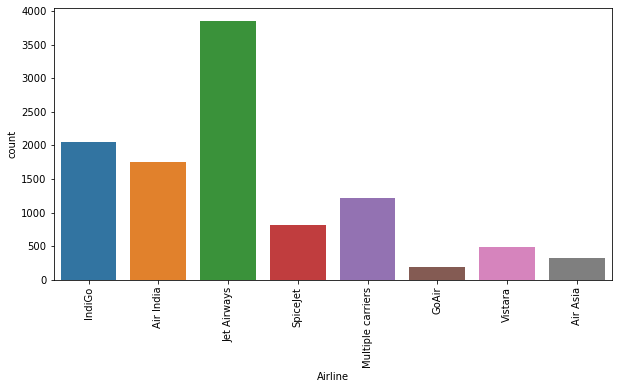

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(x='Airline',data=df_train_clean)
plt.xticks(rotation=90)
plt.show()

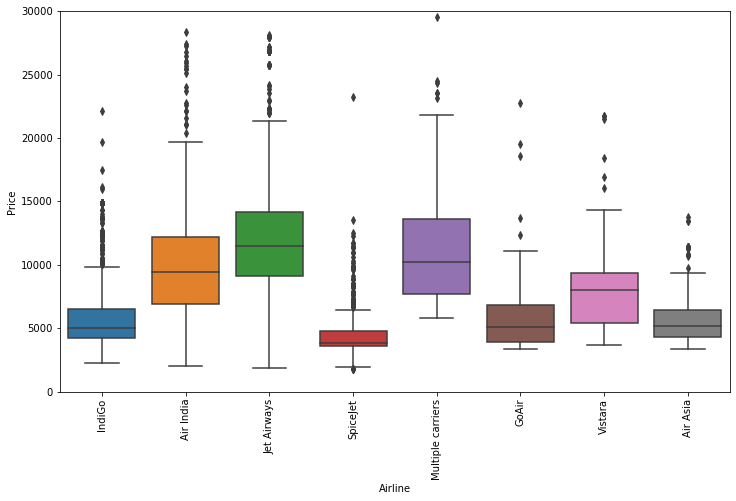

In [23]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Airline',y='Price',data=df_train_clean)
plt.xticks(rotation=90)
plt.ylim(0,30000)
plt.show()

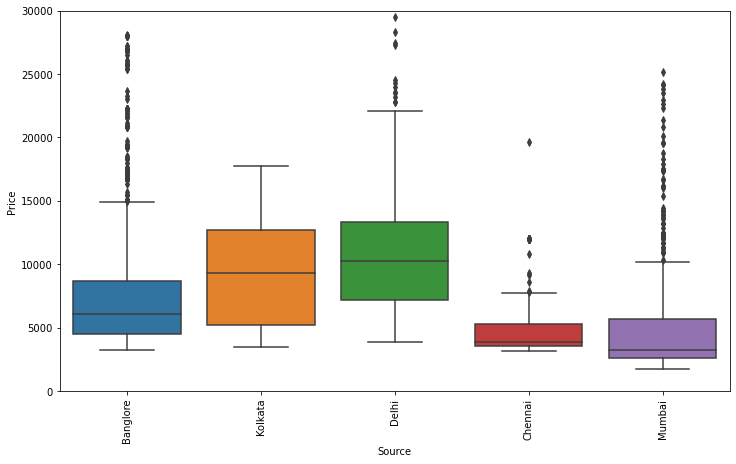

In [24]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Source',y='Price',data=df_train_clean)
plt.xticks(rotation=90)
plt.ylim(0,30000)
plt.show()

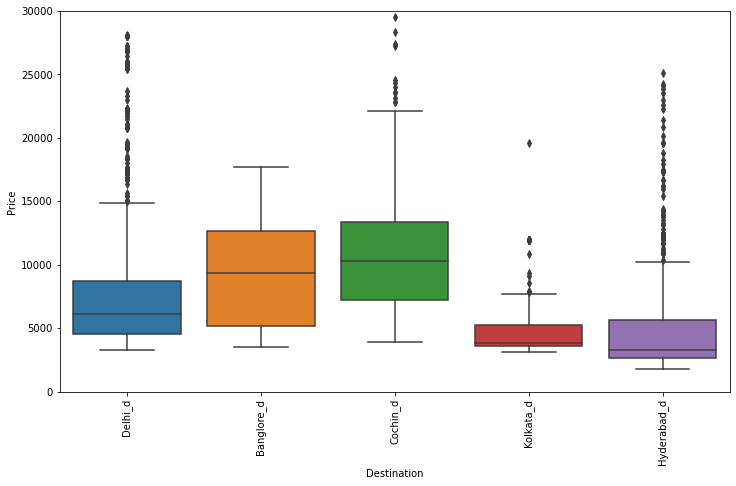

In [25]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Destination',y='Price',data=df_train_clean)
plt.xticks(rotation=90)
plt.ylim(0,30000)
plt.show()

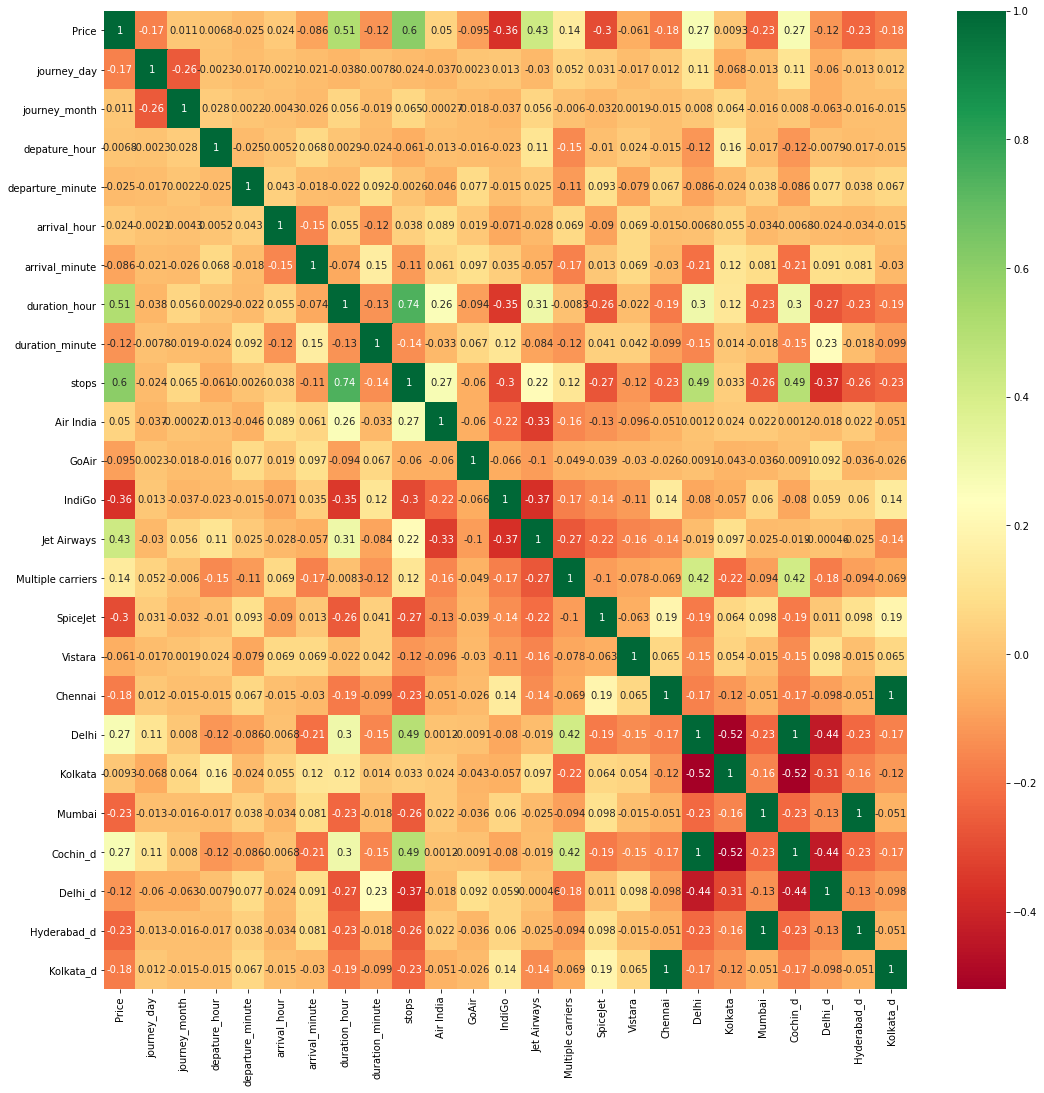

In [26]:
plt.figure(figsize = (18,18))
sns.heatmap(df_train_clean.corr(), annot = True, cmap = "RdYlGn")

In [27]:
df_train_clean.drop(['Airline','Source','Destination'], axis=1, inplace=True)
df_train_x = df_train_clean.drop('Price', axis=1)

x = df_train_x.values
y = df_train_clean['Price'].values

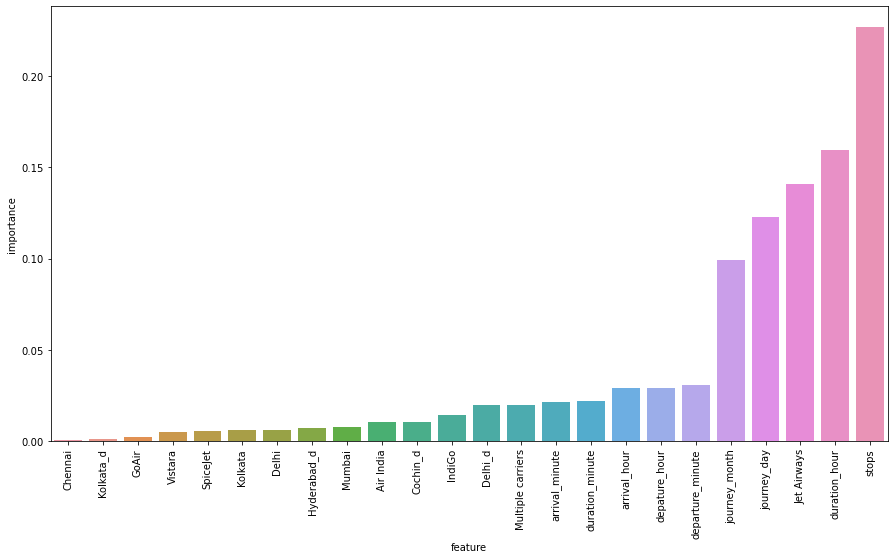

In [28]:
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(x, y)

df_feat = pd.DataFrame({'feature':df_train_x.columns,
                       'importance':selection.feature_importances_})

plt.figure(figsize = (15,8))
sns.barplot(x='feature', y='importance', 
            data=df_feat,
            order=df_feat.sort_values('importance').feature)
plt.xticks(rotation=90)
plt.show()

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=3)

In [30]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [31]:
clf = RandomForestRegressor()
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

In [32]:
print('Accuracy:', clf.score(x_test,y_test))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Accuracy: 0.7923859603740233
MAE: 1201.3545836422975
MSE: 4113149.2628083737
RMSE: 2028.0900529336398


In [33]:
clf = RandomForestRegressor(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
                  'bootstrap': [True],
                  'max_depth': [15, 20, 25],
                  'max_features': ['auto','sqrt', 10],
                  'min_samples_leaf': [2,3],
                  'min_samples_split': [2,3]}
                                  
clf_cv = GridSearchCV(clf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
clf_cv.fit(x_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 35.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [15, 20, 25],
                         'max_features': ['auto', 'sqrt', 10],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [400, 450, 500, 550]},
             verbose=True)

In [34]:
y_pred = clf_cv.predict(x_test)

In [35]:
print('Accuracy:', clf_cv.score(x_test,y_test))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Accuracy: 0.8276841633790131
MAE: 1164.129280813254
MSE: 3413838.2820577817
RMSE: 1847.6575121103429


In [36]:
clf_cv.best_params_

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 550}

In [37]:
clf_cv.best_score_

0.8160179490153844

In [38]:
clf_cv.best_estimator_

RandomForestRegressor(max_depth=15, max_features=10, min_samples_leaf=2,
                      n_estimators=550, random_state=1)

In [39]:
#import pickle

#file = open('model.pkl', 'wb')
#pickle.dump(clf_cv.best_estimator_, file)

#file = open('scaler.pkl', 'wb')
#pickle.dump(scaler, file)

In [40]:
from joblib import dump, load
dump(scaler, 'std_scaler.bin', compress=True)
dump(clf_cv.best_estimator_, 'model.bin', compress=True)

['model.bin']